# Solving in Python with LeNet

In this example, we'll explore learning with Caffe in Python, using the fully-exposed `Solver` interface.

### 1. Setup

* Set up the Python environment: we'll use the `pylab` import for numpy and plot inline.

In [3]:
from pylab import *
%matplotlib inline

* Import `caffe`, adding it to `sys.path` if needed. Make sure you've built pycaffe.

In [4]:
caffe_root = '../'  # this file should be run from {caffe_root}/examples (otherwise change this line)

import sys
sys.path.insert(0, caffe_root + 'python')
import caffe

* We'll be using the provided LeNet example data and networks (make sure you've downloaded the data and created the databases, as below).

In [5]:
## set random seeds
import numpy as np
np.random.seed(10)
caffe.set_random_seed(10)

In [6]:
# run scripts from caffe root
import os
os.chdir(caffe_root)
# Download data
!data/cifar10/get_cifar10.sh
# Prepare data
!examples/cifar10/create_cifar10.sh
# back to examples
os.chdir('examples')

Downloading...
--2020-08-11 16:21:51--  http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170052171 (162M) [application/x-gzip]
Saving to: 'cifar-10-binary.tar.gz'

100%[======================================>] 170,052,171 19.9MB/s   in 7.4s   

2020-08-11 16:21:59 (21.8 MB/s) - 'cifar-10-binary.tar.gz' saved [170052171/170052171]

Unzipping...
Done.
Creating lmdb...
I0811 16:22:01.989315   322 db_lmdb.cpp:35] Opened lmdb examples/cifar10/cifar10_train_lmdb
I0811 16:22:01.989567   322 convert_cifar_data.cpp:52] Writing Training data
I0811 16:22:01.989571   322 convert_cifar_data.cpp:55] Training Batch 1
I0811 16:22:02.016808   322 convert_cifar_data.cpp:55] Training Batch 2
I0811 16:22:02.045200   322 convert_cifar_data.cpp:55] Training Batch 3
I0811 16:22:02.074851   322 conver

### 2. Creating the net 

Now let's make a variant of LeNet, the classic 1989 convnet architecture.

We'll need two external files to help out:
* the net `prototxt`, defining the architecture and pointing to the train/test data
* the solver `prototxt`, defining the learning parameters

We start by creating the net. We'll write the net in a succinct and natural way as Python code that serializes to Caffe's protobuf model format.

This network expects to read from pregenerated LMDBs, but reading directly from `ndarray`s is also possible using `MemoryDataLayer`.

In [18]:
from caffe import layers as L, params as P

def lenet(lmdb, batch_size):
    # our version of LeNet: a series of linear and simple nonlinear transformations
    n = caffe.NetSpec()
    
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,
                             transform_param=dict(scale=1./255),image_data_param=dict(is_color=False), ntop=2)
    
    n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=6, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.relu1 = L.ReLU(n.pool1, in_place=True)
    n.conv2 = L.Convolution(n.relu1, kernel_size=5, num_output=16, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.relu2 = L.ReLU(n.pool2, in_place=True)
    n.fc1 =   L.InnerProduct(n.relu2, num_output=120, weight_filler=dict(type='xavier'))
    n.relu3 = L.ReLU(n.fc1, in_place=True)
    n.fc2 =   L.InnerProduct(n.relu3, num_output=84, weight_filler=dict(type='xavier'))
    n.relu4 = L.ReLU(n.fc2, in_place=True)
    n.score = L.InnerProduct(n.relu4, num_output=10, weight_filler=dict(type='xavier'))
    n.loss =  L.SoftmaxWithLoss(n.score, n.label)
    
    return n.to_proto()
    
with open('cifar10/lenet_auto_train.prototxt', 'w') as f:
    f.write(str(lenet('cifar10/cifar10_train_lmdb', 1000)))
    
with open('cifar10/lenet_auto_test.prototxt', 'w') as f:
    f.write(str(lenet('cifar10/cifar10_test_lmdb', 10000)))

The net has been written to disk in a more verbose but human-readable serialization format using Google's protobuf library. You can read, write, and modify this description directly. Let's take a look at the train net.

In [19]:
!cat cifar10/lenet_auto_train.prototxt

layer {
  name: "data"
  type: "Data"
  top: "data"
  top: "label"
  transform_param {
    scale: 0.00392156862745
  }
  data_param {
    source: "cifar10/cifar10_train_lmdb"
    batch_size: 1000
    backend: LMDB
  }
  image_data_param {
    is_color: false
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  convolution_param {
    num_output: 6
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "relu1"
  type: "ReLU"
  bottom: "pool1"
  top: "pool1"
}
layer {
  name: "conv2"
  type: "Convolution"
  bottom: "pool1"
  top: "conv2"
  convolution_param {
    num_output: 16
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "pool2"
  type: "Pooling"
  bottom: "conv2"
  top: "pool2"
  pooling_param {
    pool: MAX
    kernel_size: 2
    str

Now let's see the learning parameters, which are also written as a `prototxt` file (already provided on disk). We're using SGD with momentum, weight decay, and a specific learning rate schedule.

In [20]:
!cat cifar10/lenet_auto_solver.prototxt

# The train/test net protocol buffer definition
train_net: "cifar10/lenet_auto_train.prototxt"
test_net: "cifar10/lenet_auto_test.prototxt"
# test_iter specifies how many forward passes the test should carry out.
# In the case of MNIST, we have test batch size 1000 and 10 test iterations,
# covering the full 10,000 testing images.
test_iter: 10
# Carry out testing every 500 training iterations.
test_interval: 50
# The base learning rate, momentum and the weight decay of the network.
base_lr: 0.1
momentum: 0.5
weight_decay: 0
# The learning rate policy
lr_policy: "fixed"
gamma: 0
power: 0.75
# Display every 100 iterations
display: 10
# The maximum number of iterations
max_iter: 10000
# snapshot intermediate results
snapshot: 5000
snapshot_prefix: "cifar10/lenet"


### 3. Loading and checking the solver

* Let's pick a device and load the solver. We'll use SGD (with momentum), but other methods (such as Adagrad and Nesterov's accelerated gradient) are also available.

In [21]:
## set gpu
caffe.set_device(1)
caffe.set_mode_gpu()

### load the solver and create train and test nets
solver = None  # ignore this workaround for lmdb data (can't instantiate two solvers on the same data)
solver = caffe.SGDSolver('cifar10/lenet_auto_solver.prototxt')

* To get an idea of the architecture of our net, we can check the dimensions of the intermediate features (blobs) and parameters (these will also be useful to refer to when manipulating data later).

In [22]:
# each output is (batch size, feature dim, spatial dim)
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (1000, 3, 32, 32)),
 ('label', (1000,)),
 ('conv1', (1000, 6, 28, 28)),
 ('pool1', (1000, 6, 14, 14)),
 ('conv2', (1000, 16, 10, 10)),
 ('pool2', (1000, 16, 5, 5)),
 ('fc1', (1000, 120)),
 ('fc2', (1000, 84)),
 ('score', (1000, 10)),
 ('loss', ())]

In [23]:
# just print the weight sizes (we'll omit the biases)
[(k, v[0].data.shape) for k, v in solver.net.params.items()]

[('conv1', (6, 3, 5, 5)),
 ('conv2', (16, 6, 5, 5)),
 ('fc1', (120, 400)),
 ('fc2', (84, 120)),
 ('score', (10, 84))]

In [24]:
# solver.net.forward()  # train net
# solver.test_nets[0].forward()  # test net (there can be more than one)

### 4. Stepping the solver

Both train and test nets seem to be loading data, and to have correct labels.

* Let's take one step of (minibatch) SGD and see what happens.

In [25]:
# solver.step(1)

### 5. Writing a custom training loop

Something is happening. Let's run the net for a while, keeping track of a few things as it goes.
Note that this process will be the same as if training through the `caffe` binary. In particular:
* logging will continue to happen as normal
* snapshots will be taken at the interval specified in the solver prototxt (here, every 5000 iterations)
* testing will happen at the interval specified (here, every 500 iterations)

Since we have control of the loop in Python, we're free to compute additional things as we go, as we show below. We can do many other things as well, for example:
* write a custom stopping criterion
* change the solving process by updating the net in the loop

In [26]:
niter = 5000
test_interval = 50
# losses will also be stored in the log
train_loss = zeros(niter)
test_loss = zeros(int(np.ceil(niter / test_interval)))
test_acc = zeros(int(np.ceil(niter / test_interval)))
train_acc = zeros(int(np.ceil(niter / test_interval)))
output = zeros((niter, 8, 10))

import time
start_time = time.time()
# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    if it % test_interval == 0:
        idx = int(np.ceil(it/test_interval))
        print('Iteration', it, 'testing...')
        solver.test_nets[0].forward()
        test_loss[idx] = solver.test_nets[0].blobs['loss'].data
        correct = sum(solver.test_nets[0].blobs['score'].data.argmax(1)
                                == solver.test_nets[0].blobs['label'].data)
        test_acc[idx] = correct/10000.0
        print('Test accuracy :',test_acc[idx])
        correct = sum(solver.net.blobs['score'].data.argmax(1)
                        == solver.net.blobs['label'].data)
        train_acc[idx] = correct/1000.0
        print('Train accuracy :',train_acc[idx])
        
        
print("--- Training Time - %s seconds ---" % (time.time() - start_time))

('Iteration', 0, 'testing...')
('Test accuracy :', 0.1071)
('Train accuracy :', 0.107)
('Iteration', 50, 'testing...')
('Test accuracy :', 0.1983)
('Train accuracy :', 0.171)
('Iteration', 100, 'testing...')
('Test accuracy :', 0.1864)
('Train accuracy :', 0.185)
('Iteration', 150, 'testing...')
('Test accuracy :', 0.2614)
('Train accuracy :', 0.29)
('Iteration', 200, 'testing...')
('Test accuracy :', 0.3077)
('Train accuracy :', 0.28)
('Iteration', 250, 'testing...')
('Test accuracy :', 0.3329)
('Train accuracy :', 0.345)
('Iteration', 300, 'testing...')
('Test accuracy :', 0.3994)
('Train accuracy :', 0.389)
('Iteration', 350, 'testing...')
('Test accuracy :', 0.4343)
('Train accuracy :', 0.434)
('Iteration', 400, 'testing...')
('Test accuracy :', 0.4324)
('Train accuracy :', 0.441)
('Iteration', 450, 'testing...')
('Test accuracy :', 0.4551)
('Train accuracy :', 0.451)
('Iteration', 500, 'testing...')
('Test accuracy :', 0.4399)
('Train accuracy :', 0.457)
('Iteration', 550, 'testin

In [16]:
print(test_acc)

[0.0875 0.1563 0.1058 0.1795 0.2526 0.288  0.3575 0.3804 0.3925 0.3996
 0.4294 0.3637 0.4383 0.377  0.3368 0.4842 0.3869 0.5002 0.5103 0.512
 0.5011 0.4126 0.476  0.4637 0.4163 0.5164 0.4879 0.5257 0.5187 0.5162
 0.5407 0.5514 0.5466 0.5482 0.5294 0.526  0.5533 0.536  0.5359 0.5407
 0.5586 0.5526 0.5424 0.5504 0.5502 0.5351 0.5481 0.5351 0.5317 0.5448
 0.5382 0.5187 0.5425 0.5399 0.5411 0.5305 0.5427 0.5371 0.542  0.543
 0.5332 0.5286 0.5352 0.5333 0.5261 0.534  0.531  0.5364 0.5232 0.5283
 0.5249 0.5238 0.5192 0.5157 0.5149 0.5046 0.516  0.5286 0.5282 0.5168
 0.5285 0.5334 0.5258 0.5212 0.5137 0.5161 0.5177 0.508  0.5103 0.5151
 0.515  0.5157 0.5149 0.5166 0.5094 0.5173 0.5119 0.5098 0.51   0.4958]


In [27]:
print(train_loss[4999])
print(test_loss[49])

0.6901099681854248
1.453701138496399


* Let's plot the train loss and test accuracy.

Text(0.5,1,'Test Accuracy: 0.51')

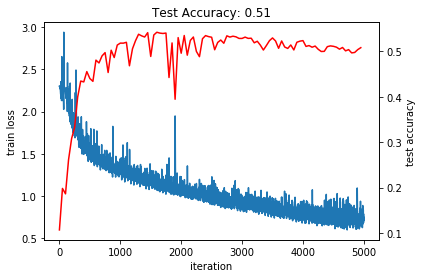

In [28]:
_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss)
ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('Test Accuracy: {:.2f}'.format(test_acc[-1]))

Text(0.5,1,'Test Accuracy: 0.51')

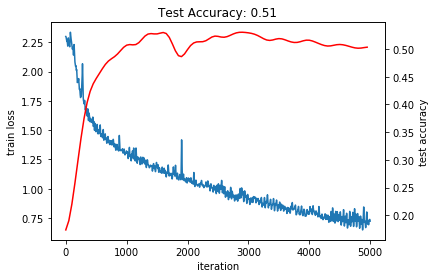

In [34]:
from scipy.ndimage.filters import gaussian_filter1d

test_acc_smooth = gaussian_filter1d(test_acc, sigma=2)
train_loss_smooth = gaussian_filter1d(train_loss, sigma=4)
_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss_smooth)
ax2.plot(test_interval * arange(len(test_acc_smooth)), test_acc_smooth, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('Test Accuracy: {:.2f}'.format(test_acc[-1]))